# Соберем сверточную нейронную сеть LiNet5

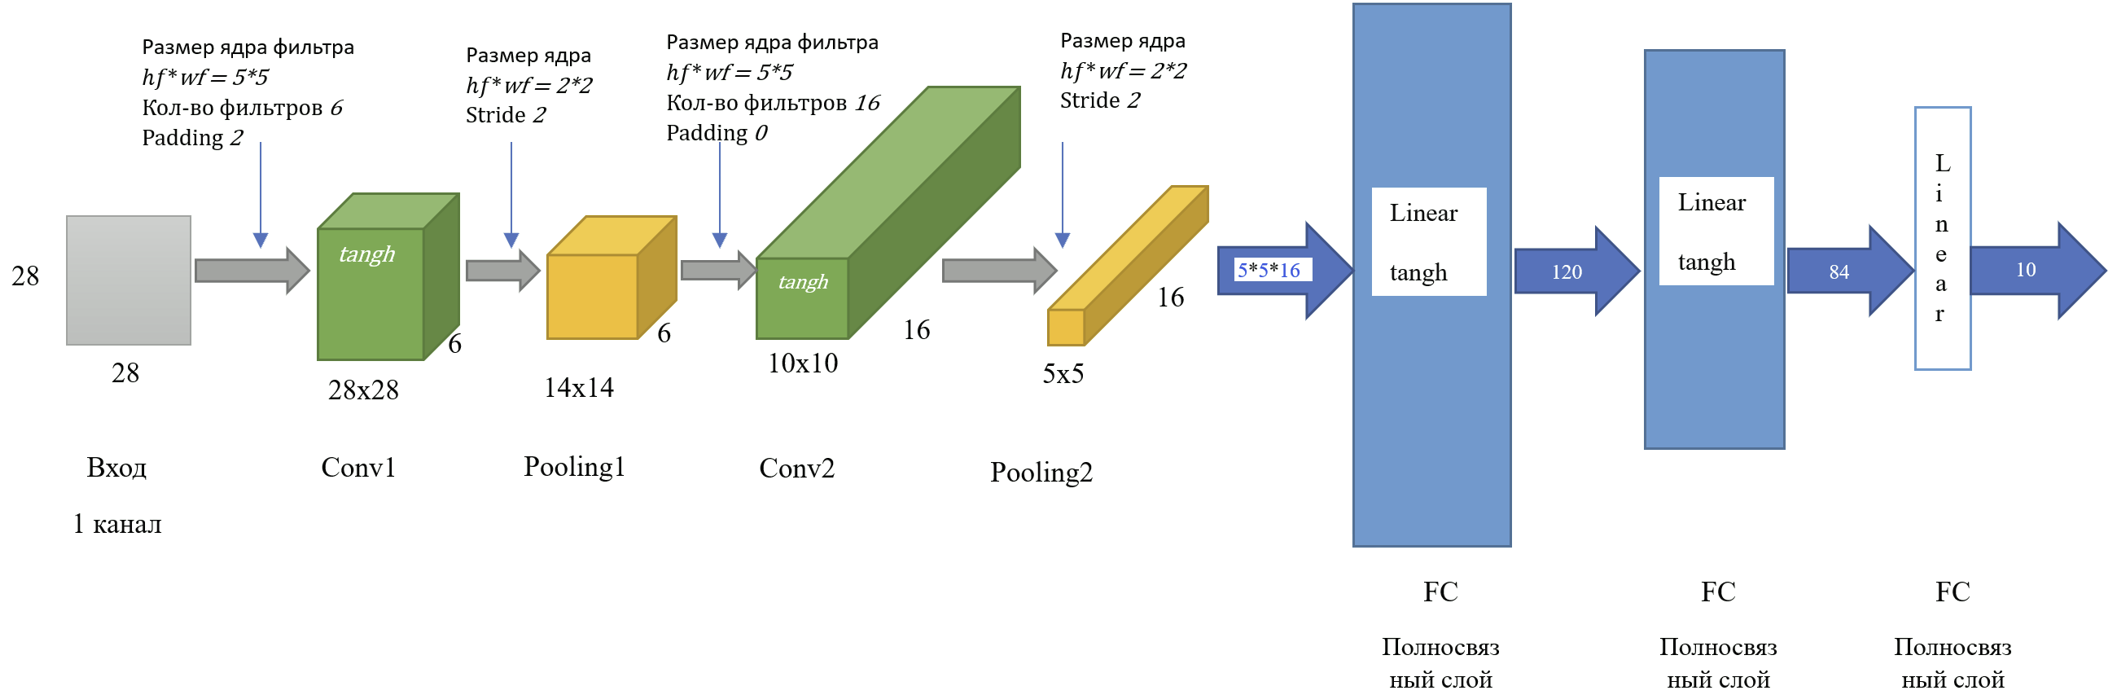


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет 28 × 28, функция активации tangh;
**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет 14 × 14, функция активации AvgPooling;
**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет 10 × 10, функция активации tangh;
**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет 5 × 5, функция активации AvgPooling;
**Слой FC** представляет собой полносвязанный слой, вход 5*5*16 нейронов (признаков), выход 120 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 120 нейронов (признаков), выход 84 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 84 нейронов (признаков), выход 10 нейронов;



In [ ]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
# это для cuda .
#torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|--------------------------------------------------

In [ ]:
# это для cuda. принудительно освобождение памяти, что иногда, но очень редко, помогает решить проблему с отказом
# cuda использовать память
#import gc
#gc.collect()

#torch.cuda.empty_cache()

In [ ]:
# будем использовать встроенные датасеты торча.
# полный список - тут https://pytorch.org/vision/stable/datasets.html

# https://cs.stanford.edu/~acoates/stl10/
import torchvision.datasets

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader

                                  # Определяем преобразования данных
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Изменение размера изображений до 96x96 пикселей
    transforms.ToTensor(),        # Конвертация изображений в тензоры
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

# Загружаем набор данных
stl10_train = STL10(root='./data', split='train', transform=transform, download=True)
stl10_test = STL10(root='./data', split='test', transform=transform, download=True)
stl10_unlabeled = STL10(root='./data', split='unlabeled', transform=transform, download=True)

# Создаем загрузчики данных
train_loader = DataLoader(stl10_train, batch_size=32, shuffle=True)
test_loader = DataLoader(stl10_test, batch_size=32, shuffle=False)
unlabeled_loader = DataLoader(stl10_unlabeled, batch_size=32, shuffle=True)

# Пример итерации по данным
for images, labels in train_loader:
    print(f'Batch size: {images.shape}')  # Выводит размер батча изображений
    print(f'Labels: {labels.shape}')      # Выводит размер батча меток
    break                                 # Выход после первого батча


100%|██████████| 2640397119/2640397119 [02:27<00:00, 17936667.12it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Batch size: torch.Size([32, 3, 96, 96])
Labels: torch.Size([32])


In [ ]:
# Формируем x_train и y_train
x_train = []
y_train = []

for images, labels in train_loader:
    x_train.append(images)
    y_train.append(labels)

# Конвертируем в тензоры
x_train = torch.cat(x_train)  # Объединяем все изображения в один тензор
y_train = torch.cat(y_train)  # Объединяем все метки в один тензор

# Формируем x_test и y_test
x_test = []
y_test = []

for images, labels in test_loader:
    x_test.append(images)
    y_test.append(labels)

# Конвертируем в тензоры
x_test = torch.cat(x_test)  # Объединяем все тестовые изображения в один тензор
y_test = torch.cat(y_test)  # Объединяем все тестовые метки в один тензор


In [ ]:
# Печатаем размеры полученных данных
print(f'x_train shape: {x_train.shape}')  # Размеры обучающих изображений
print(f'y_train shape: {y_train.shape}')  # Размеры обучающих меток
print(f'x_test shape: {x_test.shape}')    # Размеры тестовых изображений
print(f'y_test shape: {y_test.shape}')    # Размеры тестовых меток

x_train shape: torch.Size([5000, 3, 96, 96])
y_train shape: torch.Size([5000])
x_test shape: torch.Size([8000, 3, 96, 96])
y_test shape: torch.Size([8000])


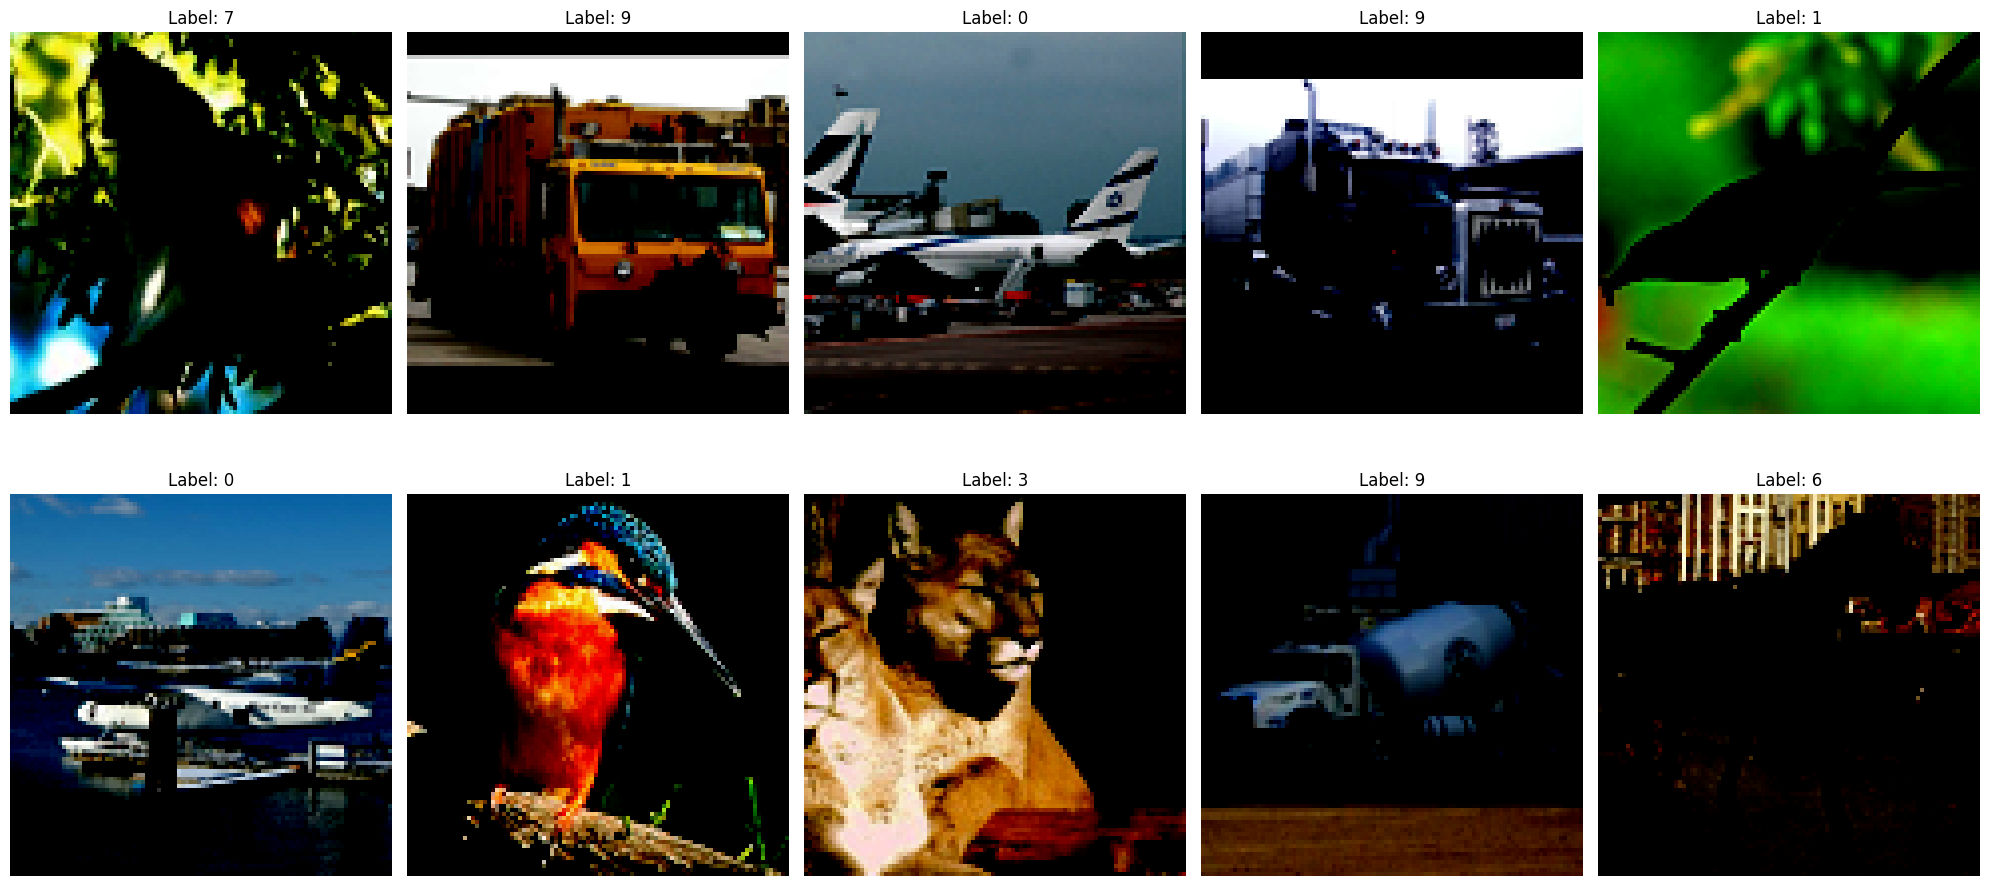

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры для выборки и визуализации
sample_size = 10  # количество изображений для визуализации

# Инициализация графика
plt.figure(figsize=(20, 10))

# Случайная выборка индексов изображений
indices = np.random.permutation(x_train.shape[0])[:sample_size]

for count, i in enumerate(indices):
    plt.subplot(2, 5, count + 1)  # Разделение на 2 строки и 5 колонок
    plt.imshow(x_train[i].permute(1, 2, 0).numpy(), cmap='viridis')  # Преобразуем (C, H, W) в (H, W, C) для отображения
    plt.title(f'Label: {y_train[i].item()}')  # Отображаем метку
    plt.axis('off')                           # Убираем оси

plt.tight_layout()
plt.show()


In [ ]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(5000, 8000)

image:
[[[-0.0745098  -0.04313725 -0.04313725 ... -0.4980392  -0.56078434
   -0.54509807]
  [-0.10588235 -0.08235294 -0.05882353 ... -0.38039213 -0.4980392
   -0.56078434]
  [-0.1607843  -0.09803921 -0.06666666 ... -0.29411763 -0.4352941
   -0.5372549 ]
  ...
  [-0.5529412  -0.62352943 -0.5686275  ... -0.41176468 -0.18431371
   -0.11372548]
  [-0.60784316 -0.654902   -0.64705884 ... -0.30196077 -0.3960784
   -0.05882353]
  [-0.654902   -0.6627451  -0.64705884 ... -0.2235294  -0.1607843
   -0.05882353]]

 [[-0.09019607 -0.05098039 -0.03529412 ... -0.3333333  -0.41960782
   -0.44313723]
  [-0.14509803 -0.09803921 -0.05098039 ... -0.18431371 -0.34117645
   -0.45098037]
  [-0.16862744 -0.11372548 -0.09019607 ... -0.09803921 -0.29411763
   -0.41960782]
  ...
  [-0.6313726  -0.8352941  -0.6784314  ... -0.58431375 -0.26274508
   -0.21568626]
  [-0.6862745  -0.81960785 -0.85882354 ... -0.41176468 -0.5529412
   -0.10588235]
  [-0.85882354 -0.85882354 -0.85882354 ... -0.4352941  -0.29411763
   -

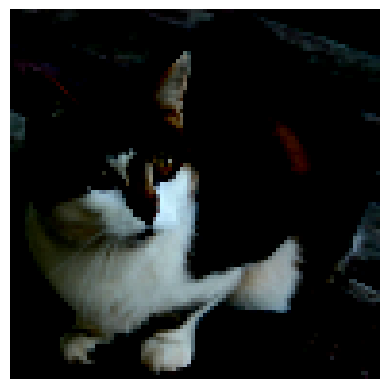

Label: 3


In [ ]:
import matplotlib.pyplot as plt

# Номер изображения для отображения
im_number = 10

# Выводим массив изображения
print(f"image:\n{x_train[im_number].numpy()}")  # Преобразуем в numpy для вывода

# Отображаем изображение
plt.imshow(x_train[im_number].permute(1, 2, 0).numpy())  # Перемещаем оси для отображения (C, H, W) -> (H, W, C)
plt.axis('off')  # Убираем оси
plt.show()

# Выводим метку изображения
print(f'Label: {y_train[im_number].item()}')  # Используем item() для получения значения метки


In [ ]:
# Номер изображения для анализа
im_number = 10

# Получаем изображение
image = x_train[im_number]

# Смотрим тип изображения
print(f"Тип изображения: {type(image)}")
print(f"Форма изображения: {image.shape}")  # Форма в формате (C, H, W)
print(f"Тип данных: {image.dtype}")


Тип изображения: <class 'torch.Tensor'>
Форма изображения: torch.Size([3, 96, 96])
Тип данных: torch.float32


In [ ]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([60000, 28, 28])  ---- станет torch.Size([60000, 1, 28, 28])
# и все значения - во float

# x_train = x_train.unsqueeze(1).float()
# x_test = x_test.unsqueeze(1).float()

In [ ]:
x_train.shape

torch.Size([5000, 3, 96, 96])

In [ ]:
x_test.shape

torch.Size([8000, 3, 96, 96])

In [ ]:
import torch

class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # на вход 3 канала
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # Изменяем размер входа на 7744 для первого полносвязного слоя
        # первый свёрточный слой - 96 * 96 ... (96 - 5 + 4*1) + 1  = 96
        # второй слой "self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)' пуллинг 48*48
        # второй свёрточный слов вход - 6 каналов, выход 16 каналов, размер сетки 5, добавочные пиксели 0
        # (48 - 5 + 0*1) + 1 = 44
        # второй слой пуллинга - 22 *22, 16 каналов
        self.fc1   = torch.nn.Linear(16 * 22 * 22, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)  # 10 классов

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
#  доступна ли CUDA
# CUDA позволяет использовать графические процессоры (GPU) для ускорения вычислений в PyTorch
# если доступно используем GPU (первый доступный - 'cuda:0'), иначе CPU

# Инициализация модели
lenet5 = LeNet5().to(device)


# ЕСЛИ ВЫ ОБУЧИТЕ НЕЙРОНКУ НА GPU или CPU ОНА ДЛЯ СВОЕЙ РАБОТЫ БУДЕТ ТРЕБОВАТЬ ИЛИ GPU, ИЛИ CPU
Поэтому не всегда возможно использование обучения на GPU просто потому, что сервер или компьютер пользователя не будет поддерживать расчеты на GPU

In [ ]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [ ]:
# Будем оптимизировать по 100 параметров за один проход (батч)
batch_size = 100

# Для хранения истории точности и потерь
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

# Отправляем все выборки на устройство, на котором обучаем
x_test = x_test.to(device)
y_test = y_test.to(device)

# Количество эпох
epochs = 100

for epoch in range(epochs):
    # Перемешиваем порядок обучения
    order = np.random.permutation(len(x_train))

    for start_index in range(0, len(x_train), batch_size):
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Получаем индексы для текущей пачки
        batch_indexes = order[start_index:start_index + batch_size]

        # Берём текущий батч данных
        x_batch = x_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # Делаем предсказание
        preds = lenet5(x_batch)  # Можно использовать lenet5(x_batch) вместо lenet5.forward(x_batch)

        # Вычисляем значение потерь
        loss_value = loss(preds, y_batch)

        # Получаем градиенты
        loss_value.backward()

        # Выполняем оптимизацию
        optimizer.step()

    # Сохраняем данные о обучении
    train_loss_history.append(loss_value.item())  # Используем .item() для получения значения

    # Проверяем модель на тестовых данных
    with torch.no_grad():  # Отключаем вычисление градиентов для теста
        test_preds = lenet5(x_test)
        test_loss_history.append(loss(test_preds, y_test).item())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()  # .item() для получения скалярного значения
        test_accuracy_history.append(accuracy)

    # Выводим результаты текущей эпохи
    print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {accuracy:.4f}")


Epoch 1/100 - Accuracy: 0.3506
Epoch 2/100 - Accuracy: 0.3774
Epoch 3/100 - Accuracy: 0.4065
Epoch 4/100 - Accuracy: 0.4113
Epoch 5/100 - Accuracy: 0.4266
Epoch 6/100 - Accuracy: 0.4175
Epoch 7/100 - Accuracy: 0.4193
Epoch 8/100 - Accuracy: 0.4119
Epoch 9/100 - Accuracy: 0.4068
Epoch 10/100 - Accuracy: 0.4068
Epoch 11/100 - Accuracy: 0.3988
Epoch 12/100 - Accuracy: 0.4004
Epoch 13/100 - Accuracy: 0.3971
Epoch 14/100 - Accuracy: 0.3914
Epoch 15/100 - Accuracy: 0.3976
Epoch 16/100 - Accuracy: 0.3978
Epoch 17/100 - Accuracy: 0.3948
Epoch 18/100 - Accuracy: 0.3955
Epoch 19/100 - Accuracy: 0.3954
Epoch 20/100 - Accuracy: 0.3946
Epoch 21/100 - Accuracy: 0.3965
Epoch 22/100 - Accuracy: 0.3953
Epoch 23/100 - Accuracy: 0.3941
Epoch 24/100 - Accuracy: 0.3960
Epoch 25/100 - Accuracy: 0.3959
Epoch 26/100 - Accuracy: 0.3956
Epoch 27/100 - Accuracy: 0.3950
Epoch 28/100 - Accuracy: 0.3945
Epoch 29/100 - Accuracy: 0.3949
Epoch 30/100 - Accuracy: 0.3935
Epoch 31/100 - Accuracy: 0.3948
Epoch 32/100 - Ac

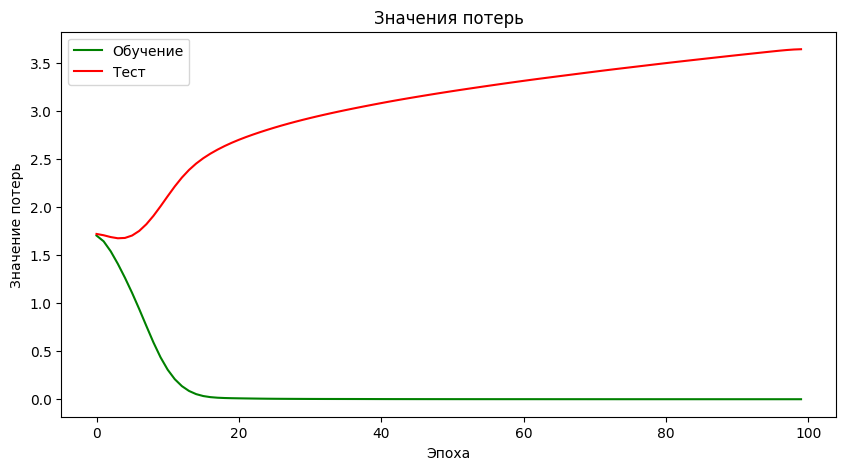

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Строим графики - функции потерь
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set(title='Значения потерь',
       xlabel='Эпоха',
       ylabel='Значение потерь')

train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green', label='Обучение')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red', label='Тест')

ax.legend()
plt.show()



<ipython-input-95-7ea75e20b699>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


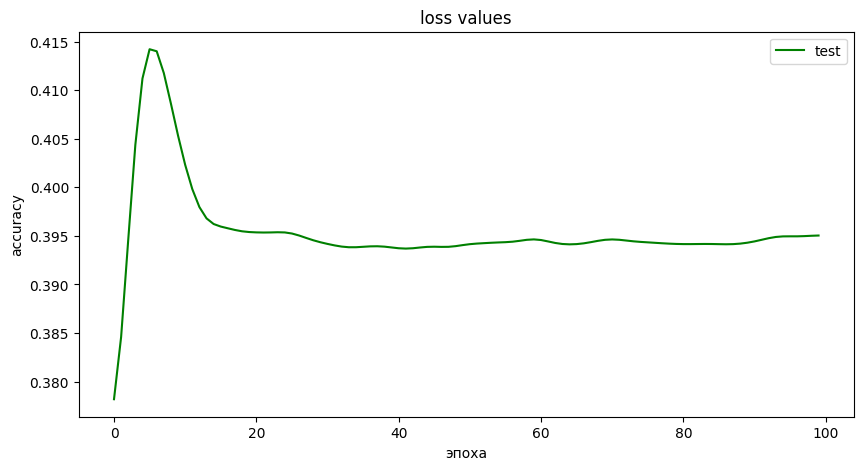

In [ ]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [ ]:
# сохраняем произвольное число из датасета (тензор) в файл
timg = x_test[10]

torch.save(timg,'tensor.pt')


In [ ]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([3, 96, 96])

In [ ]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

x_test.size()

torch.Size([8000, 3, 96, 96])

In [ ]:
# Установка dill - выполните это в вашем окружении
!pip install dill

# Сохранение модели с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)



In [ ]:
# вот так сохраняют модель с помощью pickle
# import pickle

# with open("model.pickle", "wb") as pickle_file:
#     pickle.dump(lenet5, pickle_file)



In [ ]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
#from LeNET_5 import LeNet
import pandas as pd
import numpy as np



ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


<ipython-input-100-58d101a88a51>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

In [ ]:
print(test_data.shape)
test_data


torch.Size([3, 96, 96])


tensor([[[-0.6235, -0.6314, -0.6235,  ..., -0.6471, -0.6314, -0.6314],
         [-0.6314, -0.6235, -0.6157,  ..., -0.6471, -0.6549, -0.6471],
         [-0.6314, -0.6157, -0.6235,  ..., -0.6235, -0.6392, -0.6235],
         ...,
         [-0.6314, -0.6235, -0.6157,  ..., -0.6235, -0.6157, -0.6314],
         [-0.6235, -0.6235, -0.6314,  ..., -0.6314, -0.6235, -0.6235],
         [-0.6314, -0.6314, -0.6157,  ..., -0.6235, -0.6157, -0.6235]],

        [[-0.2784, -0.2863, -0.2784,  ..., -0.3098, -0.3020, -0.3020],
         [-0.2863, -0.2941, -0.2784,  ..., -0.2941, -0.3020, -0.3020],
         [-0.2863, -0.2863, -0.2863,  ..., -0.2941, -0.2941, -0.3020],
         ...,
         [-0.2706, -0.2627, -0.2706,  ..., -0.2627, -0.2627, -0.2863],
         [-0.2627, -0.2784, -0.2627,  ..., -0.2627, -0.2784, -0.2784],
         [-0.2706, -0.2706, -0.2706,  ..., -0.2706, -0.2706, -0.2627]],

        [[ 0.2000,  0.1922,  0.2000,  ...,  0.1686,  0.1843,  0.1843],
         [ 0.1922,  0.1922,  0.2000,  ...,  0

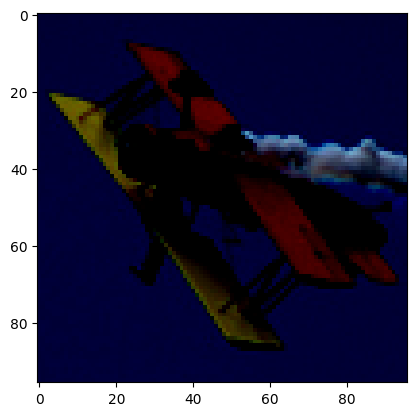

In [ ]:
# Предположим, что test_data - это тензор PyTorch с формой (3, 96, 96)
# Сначала убедитесь, что вы переместили его на CPU, если он на GPU
test_data = test_data.cpu()

# Измените размерность
test_data = test_data.permute(1, 2, 0)  # Теперь будет (96, 96, 3)

# Теперь можно отобразить изображение
plt.imshow(test_data)
plt.show()

In [ ]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

In [ ]:
# проверяем
t_data.shape

torch.Size([1, 96, 96, 3])

In [ ]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [ ]:
# делаем предсказание
# При условии, что t_data в форме (1, 96, 96, 3)
t_data = t_data.permute(0, 3, 1, 2)  # Преобразует в (1, 3, 96, 96)

# Теперь проводим предсказание
preds = modelp.forward(t_data)

In [ ]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[ 3.4192, -3.0041,  0.0989, -1.5906, -5.1816, -1.8836,  4.0048,  1.3553,
         -0.9971,  5.2001]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [ ]:
# смотрим, что предсказалось
print(prediction)

[9]


Из описания датасета

10 классов:
0 - самолёт,
1 - птица,
2 - автомобиль,
3 - кот,
4 - олень,
5 - собака,
6 - лошадь,
7 - обезьяна,
8 - корабль,
9 - грузовик.